In [5]:
import pandas as pd
import numpy as np
import math
import datetime
import matplotlib.pyplot as plt
from ipynb.fs.defs.functions import new_route
from ipynb.fs.defs.functions import get_row
from ipynb.fs.defs.functions import get_column
from ipynb.fs.defs.functions import best_index
from ipynb.fs.defs.functions import find_best_position
from ipynb.fs.defs.functions import cities_list
from ipynb.fs.defs.functions import getName
from ipynb.fs.defs.functions import check_cities
from ipynb.fs.defs.functions import timeDistance
from ipynb.fs.defs.functions import translate_name

dft = pd.read_csv("../distanze/corrected_times_computed.csv", delimiter=";", encoding = "ISO-8859-1", index_col=0)
dfd = pd.read_csv("../distanze/distances_computed.csv", delimiter=";", encoding = "ISO-8859-1", index_col=0)
times = []
kms = []
carico = []
wdays = []

In [6]:
def getTimeKm(df1, df2, missing):
    week = ["lunedi", "martedi", "mercoledi", "giovedi", "venerdi"]
    time = 0
    km = 0
    for day in week:
        if missing == True:
            time += round(timeDistance("Cremona, Sesto 39", df1[day][0], dft), 2)
            time += round(timeDistance(df1[day][len(df1[day].dropna())-1], "Ostiano, Mazzini, 1", dft), 2)
            km += round(timeDistance("Cremona, Sesto 39", df1[day][0], dfd), 2)
            km += round(timeDistance(df1[day][len(df1[day].dropna())-1], "Ostiano, Mazzini, 1", dfd), 2)
            
        time += round(sum(new_route(df1[day].dropna(), dft).values), 2)
        km += round(sum(new_route(df1[day].dropna(), dfd).values), 2)
        if day in df2.columns:
            if missing == True:
                time += round(timeDistance("Cremona, Sesto 39", df2[day][0], dft), 2)
                time += round(timeDistance(df2[day][len(df2[day].dropna())-1], "San Giovanni in Croce, Feudatari, 25 A", dft), 2)
                km += round(timeDistance("Cremona, Sesto 39", df2[day][0], dfd), 2)
                km += round(timeDistance(df2[day][len(df2[day].dropna())-1], "San Giovanni in Croce, Feudatari, 25 A", dfd), 2)
            
            time += round(sum(new_route(df2[day].dropna(), dft).values), 2)
            km += round(sum(new_route(df2[day].dropna(), dfd).values), 2)
            
    return round(time,2), round(km,2)

def getCarico(df1, df2, missing):
    sweek = ["martedi", "mercoledi", "giovedi"]
    total = 0
    diff_sum = 0
    a=0
    b=0
    for day in sweek:
        if missing == True:
            a = timeDistance("Cremona, Sesto 39", df1[day][0], dfd) + timeDistance(df1[day][len(df1[day].dropna())-1], "Ostiano, Mazzini, 1", dfd)
            total += a
            b = timeDistance("Cremona, Sesto 39", df2[day][0], dfd) + timeDistance(df2[day][len(df2[day].dropna())-1], "San Giovanni in Croce, Feudatari, 25 A", dfd)
            total += b
        total = total + sum(new_route(df1[day].dropna(), dfd).values) + sum(new_route(df2[day].dropna(), dfd).values)
        
        diff_sum = diff_sum + abs(sum(new_route(df1[day].dropna(), dfd).values)+a - sum(new_route(df2[day].dropna(), dfd).values)+b)
    return round(diff_sum/total, 2)

#Take schedulation and return a list that contains the day(in index) where the city appears
def getOccurenceDays(fur1, fur2, city, dframe, b):
    week = ["lunedi", "martedi", "mercoledi", "giovedi", "venerdi"]
    l = []
    for d in fur1.columns:
        if b == 1:
            cur_route1 = fur1[d].dropna()[1:len(fur1[d].dropna())-1]
        else:
            cur_route1 = fur1[d].dropna()
            
        if getName(dframe, city) in list(cur_route1):
            l.append(week.index(d))
            
    for d in fur2.columns:
        if b == 1:
            cur_route2 = fur2[d].dropna()[1:len(fur2[d].dropna())-1]
        else:
            cur_route2 = fur2[d].dropna()
            
        if getName(dframe, city) in list(cur_route2):
            l.append(week.index(d))
          
    return list(set(l))

def getDistance(s, e):
    if s == e:
        return 7
    if s < e:
        return e-s
    if s > e:
        return 7-(s-e)

"""def mean_wdays(fur1, fur2, city_s, city_e, dframe, b):
    s_list = getOccurenceDays(fur1, fur2, city_s, dframe, b)
    e_list = getOccurenceDays(fur1, fur2, city_e, dframe, b)
    results = []
    for s in s_list:
        for e in e_list:
            results.append(getDistance(s, e))
    
    if not results:
        return -1
    return round(sum(results) / len(results), 1)"""

def mean_wdays(fur1, fur2, city_s, city_e, dframe, b):
    s_list = getOccurenceDays(fur1, fur2, city_s, dframe, b)
    e_list = getOccurenceDays(fur1, fur2, city_e, dframe, b)
    results = []
    dists = []
    ocs = []
    for s in s_list:
        for e in e_list:
            results.append((s, e))
            dists.append(getDistance(s, e))
#         if not results:
#             #print(s_list, city_s, sep = ' $ ')
#             #print(e_list, city_e, sep = ' $ ')
#             return -1
    return dists

def compute_mean_wdays(dframe, fur1, fur2, b):
    #week = ["lunedi", "martedi", "mercoledi", "giovedi", "venerdi"]
    
    f1 = translate_name(dframe, fur1)
    f2 = translate_name(dframe, fur2)
    
    indx = [getName(dframe, x) for x in dframe.columns]
    #waiting_days = pd.DataFrame({}, index = indx, columns = indx)
    waiting_days = []
    for s in indx:
        for e in indx:
            res = mean_wdays(f1, f2, s, e, dframe, b)
            if res:
                waiting_days = waiting_days + res
            
            
    return round(sum(waiting_days)/len(waiting_days), 2)

## Original solution

In [7]:
df1 = pd.read_csv("../turni_f/original_start/f1_original.csv", delimiter=";", encoding = "ISO-8859-1")
df2 = pd.read_csv("../turni_f/original_start/f2_original.csv", delimiter=";", encoding = "ISO-8859-1")


print("Original")
time, km = getTimeKm(df1, df2, True)
times.append(time)
kms.append(km)
carico.append(getCarico(df1, df2, True))
print(f"Time: {times[-1]}  " +  
      f"Km: {kms[-1]}  " +
      f"Carico: {carico[-1]}  ")

print("\nOriginal Local Search")
df1 = pd.read_csv("../turni_f/original_start/original_ls1.csv", delimiter=";", encoding = "ISO-8859-1")
df2 = pd.read_csv("../turni_f/original_start/original_ls2.csv", delimiter=";", encoding = "ISO-8859-1")

time, km = getTimeKm(df1, df2, False)
times.append(time)
kms.append(km)
carico.append(getCarico(df1, df2, False))
print(f"Time: {times[-1]}  " +  
      f"Km: {kms[-1]}  " +
      f"Carico: {carico[-1]}  ")

print("\nOriginal 2-Opt")
df1 = pd.read_csv("../turni_f/original_start/original_2opt1.csv", delimiter=";", encoding = "ISO-8859-1")
df2 = pd.read_csv("../turni_f/original_start/original_2opt2.csv", delimiter=";", encoding = "ISO-8859-1")

time, km = getTimeKm(df1, df2, False)
times.append(time)
kms.append(km)
carico.append(getCarico(df1, df2, False))
print(f"Time: {times[-1]}  " +  
      f"Km: {kms[-1]}  " +
      f"Carico: {carico[-1]}  ")

print("\nOriginal Multi vehicle local search")
df1 = pd.read_csv("../turni_f/original_start/original_MVLS1.csv", delimiter=";", encoding = "ISO-8859-1")
df2 = pd.read_csv("../turni_f/original_start/original_MVLS2.csv", delimiter=";", encoding = "ISO-8859-1")

time, km = getTimeKm(df1, df2, False)
times.append(time)
kms.append(km)
carico.append(getCarico(df1, df2, False))
print(f"Time: {times[-1]}  " +  
      f"Km: {kms[-1]}  " 
      f"Carico: {carico[-1]}  ")


Original
Time: 1776.59  Km: 1691.72  Carico: 0.39  

Original Local Search
Time: 1568.0  Km: 1465.0  Carico: 0.18  

Original 2-Opt
Time: 1434.0  Km: 1309.0  Carico: 0.1  

Original Multi vehicle local search
Time: 1399.0  Km: 1218.0  Carico: 0.45  


## Greedy

In [8]:
df1 = pd.read_csv("../turni_f/furgoncino1_routing.csv", delimiter=";", encoding = "ISO-8859-1")
df2 = pd.read_csv("../turni_f/furgoncino2_routing.csv", delimiter=";", encoding = "ISO-8859-1")


print("Greedy")
time, km = getTimeKm(df1, df2, True)
times.append(time)
kms.append(km)
carico.append(getCarico(df1, df2, True))
print(f"Time: {times[-1]}  " +  
      f"Km: {kms[-1]}  " +
      f"Carico: {carico[-1]}  ")

print("\nGreedy Local Search")
df1 = pd.read_csv("../turni_f/ls1_shifts.csv", delimiter=";", encoding = "ISO-8859-1")
df2 = pd.read_csv("../turni_f/ls2_shifts.csv", delimiter=";", encoding = "ISO-8859-1")

time, km = getTimeKm(df1, df2, False)
times.append(time)
kms.append(km)
carico.append(getCarico(df1, df2, False))
print(f"Time: {times[-1]}  " +  
      f"Km: {kms[-1]}  " +
      f"Carico: {carico[-1]}  ")

print("\nGreedy 2-Opt")
df1 = pd.read_csv("../turni_f/2-opt1_shifts.csv", delimiter=";", encoding = "ISO-8859-1")
df2 = pd.read_csv("../turni_f/2-opt2_shifts.csv", delimiter=";", encoding = "ISO-8859-1")

time, km = getTimeKm(df1, df2, False)
times.append(time)
kms.append(km)
carico.append(getCarico(df1, df2, False))
print(f"Time: {times[-1]}  " +  
      f"Km: {kms[-1]}  " +
      f"Carico: {carico[-1]}  ")

print("\nGreedy Multi vehicle local search")
df1 = pd.read_csv("../turni_f/MVLS1.csv", delimiter=";", encoding = "ISO-8859-1")
df2 = pd.read_csv("../turni_f/MVLS2.csv", delimiter=";", encoding = "ISO-8859-1")

time, km = getTimeKm(df1, df2, False)
times.append(time)
kms.append(km)
carico.append(getCarico(df1, df2, False))
print(f"Time: {times[-1]}  " +  
      f"Km: {kms[-1]}  " +
      f"Carico: {carico[-1]}  ")


Greedy
Time: 1434.26  Km: 1304.71  Carico: 0.3  

Greedy Local Search
Time: 1378.0  Km: 1268.0  Carico: 0.3  

Greedy 2-Opt
Time: 1315.0  Km: 1222.0  Carico: 0.33  

Greedy Multi vehicle local search
Time: 1378.0  Km: 1262.0  Carico: 0.56  


## Optimized Start Schedule

In [9]:
df1 = pd.read_csv("../turni_f/optimized_start/oss_greedy1.csv", delimiter=";", encoding = "ISO-8859-1")
df2 = pd.read_csv("../turni_f/optimized_start/oss_greedy2.csv", delimiter=";", encoding = "ISO-8859-1")


print("OSS greedy")
time, km = getTimeKm(df1, df2, True)
times.append(time)
kms.append(km)
carico.append(getCarico(df1, df2, True))
print(f"Time: {times[-1]}  " +  
      f"Km: {kms[-1]}  " +
      f"Carico: {carico[-1]}  ")

print("\nOSS Local Search")
df1 = pd.read_csv("../turni_f/optimized_start/oss_ls1.csv", delimiter=";", encoding = "ISO-8859-1")
df2 = pd.read_csv("../turni_f/optimized_start/oss_ls2.csv", delimiter=";", encoding = "ISO-8859-1")

time, km = getTimeKm(df1, df2, False)
times.append(time)
kms.append(km)
carico.append(getCarico(df1, df2, False))
print(f"Time: {times[-1]}  " +  
      f"Km: {kms[-1]}  " +
      f"Carico: {carico[-1]}  ")

print("\nOSS 2-Opt")
df1 = pd.read_csv("../turni_f/optimized_start/oss_2opt_f1.csv", delimiter=";", encoding = "ISO-8859-1")
df2 = pd.read_csv("../turni_f/optimized_start/oss_2opt_f2.csv", delimiter=";", encoding = "ISO-8859-1")

time, km = getTimeKm(df1, df2, False)
times.append(time)
kms.append(km)
carico.append(getCarico(df1, df2, False))
print(f"Time: {times[-1]}  " +  
      f"Km: {kms[-1]}  " +
      f"Carico: {carico[-1]}  ")

print("\nOSS Multi vehicle local search")
df1 = pd.read_csv("../turni_f/optimized_start/oss_MVLS_f1.csv", delimiter=";", encoding = "ISO-8859-1")
df2 = pd.read_csv("../turni_f/optimized_start/oss_MVLS_f2.csv", delimiter=";", encoding = "ISO-8859-1")

time, km = getTimeKm(df1, df2, False)
times.append(time)
kms.append(km)
carico.append(getCarico(df1, df2, False))
print(f"Time: {times[-1]}  " +  
      f"Km: {kms[-1]}  " +
      f"Carico: {carico[-1]}  ")

OSS greedy
Time: 1689.26  Km: 1612.71  Carico: 0.25  

OSS Local Search
Time: 1636.0  Km: 1555.0  Carico: 0.24  

OSS 2-Opt
Time: 1475.0  Km: 1341.0  Carico: 0.19  

OSS Multi vehicle local search
Time: 1635.0  Km: 1528.0  Carico: 0.63  


## Fine Optimized Schedule Start

In [10]:
df1 = pd.read_csv("../turni_f/fine_optimized_start/foss_f1.csv", delimiter=";", encoding = "ISO-8859-1")
df2 = pd.read_csv("../turni_f/fine_optimized_start/foss_f2.csv", delimiter=";", encoding = "ISO-8859-1")


print("FOSS greedy")
time, km = getTimeKm(df1, df2, True)
times.append(time)
kms.append(km)
carico.append(getCarico(df1, df2, True))
print(f"Time: {times[-1]}  " +  
      f"Km: {kms[-1]}  " +
      f"Carico: {carico[-1]}  ")

df1 = pd.read_csv("../turni_f/fine_optimized_start/foss_MVLS1.csv", delimiter=";", encoding = "ISO-8859-1")
df2 = pd.read_csv("../turni_f/fine_optimized_start/foss_MVLS2.csv", delimiter=";", encoding = "ISO-8859-1")


print("FOSS MVLS")
time, km = getTimeKm(df1, df2, True)
times.append(time)
kms.append(km)
carico.append(getCarico(df1, df2, True))
print(f"Time: {times[-1]}  " +  
      f"Km: {kms[-1]}  " +
      f"Carico: {carico[-1]}  ")



FOSS greedy
Time: 2695.9  Km: 2713.03  Carico: 0.34  
FOSS MVLS
Time: 1394.26  Km: 1247.71  Carico: 0.48  


Original
Time: 1776.59  Km: 1691.72  Carico: 0.39  

Original Local Search
Time: 1568.0  Km: 1465.0  Carico: 0.18  

Original 2-Opt
Time: 1434.0  Km: 1309.0  Carico: 0.1  

Original Multi vehicle local search
Time: 1399.0  Km: 1218.0  Carico: 0.45 
                
Greedy
Time: 1434.26  Km: 1304.71  Carico: 0.3  

Greedy Local Search
Time: 1378.0  Km: 1268.0  Carico: 0.3  

Greedy 2-Opt
Time: 1315.0  Km: 1222.0  Carico: 0.33  

Greedy Multi vehicle local search
Time: 1378.0  Km: 1262.0  Carico: 0.56
                
OSS greedy
Time: 1689.26  Km: 1612.71  Carico: 0.25  

OSS Local Search
Time: 1636.0  Km: 1555.0  Carico: 0.24  

OSS 2-Opt
Time: 1475.0  Km: 1341.0  Carico: 0.19  

OSS Multi vehicle local search
Time: 1635.0  Km: 1528.0  Carico: 0.63 

FOSS greedy
Time: 2695.9  Km: 2713.03  Carico: 0.34  

FOSS MVLS
Time: 1394.26  Km: 1247.71  Carico: 0.48 

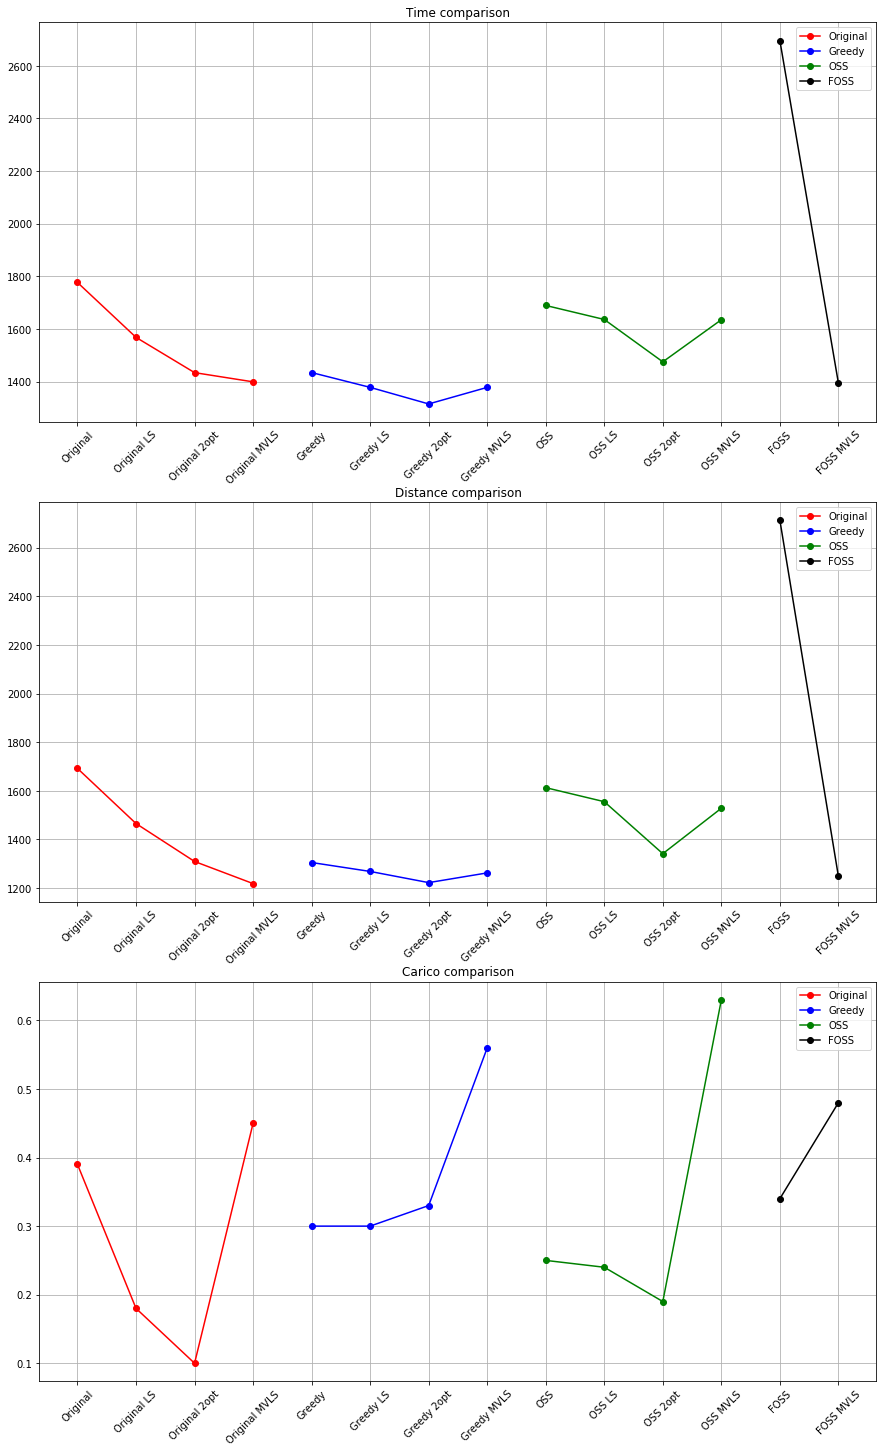

In [12]:
names = ["Original", "Original LS", "Original 2opt", "Original MVLS",
         "Greedy", "Greedy LS", "Greedy 2opt", "Greedy MVLS",
         "OSS", "OSS LS", "OSS 2opt", "OSS MVLS", "FOSS", "FOSS MVLS"]

plt.figure(figsize=[15,25])
plt.subplot(311)
plt.grid()
plt.plot(names[0:4], times[0:4], 'ro-')
plt.plot(names[4:8], times[4:8], 'bo-')
plt.plot(names[8:12], times[8:12], 'go-')
plt.plot(names[12:], times[12::], 'ko-')
plt.legend(["Original", "Greedy", "OSS", "FOSS"])
plt.xticks(rotation=45)
plt.title("Time comparison")

plt.subplot(312)
plt.grid()
plt.plot(names[0:4], kms[0:4], 'ro-')
plt.plot(names[4:8], kms[4:8], 'bo-')
plt.plot(names[8:12], kms[8:12], 'go-')
plt.plot(names[12:], kms[12:], 'ko-')
plt.legend(["Original", "Greedy", "OSS", "FOSS"])
plt.xticks(rotation=45)
plt.title("Distance comparison")

plt.subplot(313)
plt.grid()
plt.plot(names[0:4], carico[0:4], 'ro-')
plt.plot(names[4:8], carico[4:8], 'bo-')
plt.plot(names[8:12], carico[8:12], 'go-')
plt.plot(names[12:], carico[12:], 'ko-')
plt.legend(["Original", "Greedy", "OSS", "FOSS"])
plt.xticks(rotation=45)
plt.title("Carico comparison")

#plt.show()
plt.savefig('compare_results_FOSS.png')